In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

# Week 1

In [2]:
gdp = pd.read_csv("GDP.csv")
rgdp = pd.read_csv("GDPC1.csv")
m2 = pd.read_csv("M2SL.csv")

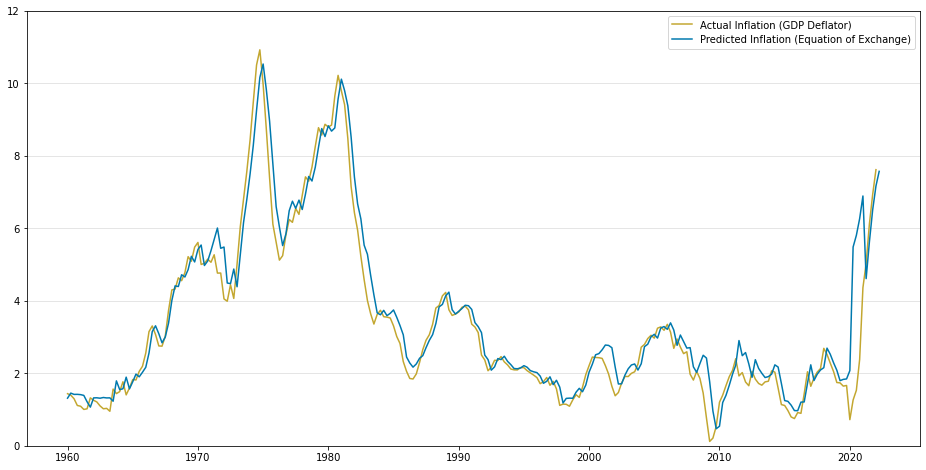

In [3]:
df = gdp.merge(rgdp, on = "DATE", how = "inner")
df = df.merge(m2, on = "DATE", how = "inner")
df["DATE"] = pd.to_datetime(df.DATE)
df = df.set_index(df.DATE)

df["M2V_CALC"] = df["GDP"] / df["M2SL"]
df["GDP_DEF"] = df["GDP"] / df["GDPC1"]
df["INF"] = df["GDP_DEF"].pct_change(periods = 4) * 100
df["delta_M"] = df["M2SL"].pct_change(periods = 4) * 100
df["delta_V"] = df["M2V_CALC"].pct_change(periods = 4) * 100
df["delta_Y"] = df["GDPC1"].pct_change(periods = 4) * 100
df["delta_P"] = df["delta_M"] + df["delta_V"] - df["delta_Y"]
pred_inf = df.delta_P
df = df.dropna(axis = 0, how = "any")

plt.figure(figsize = (16, 8))
Y1 = df["INF"].shift(-1)
Y2 = df["delta_P"]
plt.ylim([0, 12])
plt.grid(color = 'grey', linestyle = '-', linewidth = 1, alpha = 0.2, axis = "y")
plt.plot(Y1, color = "#C3A730")
plt.plot(Y2, color = "#0079AE")
location = 0
legend_drawn_flag = True
plt.legend(["Actual Inflation (GDP Deflator)", "Predicted Inflation (Equation of Exchange)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("m2_inflation.png", dpi = 120)
plt.show()

# Week 2

In [4]:
cs = pd.read_csv("Consumer Sentiment.csv", parse_dates = ["DATE"]) #From 1952-11-01 Monthly #Too many Nan PASS
ie = pd.read_csv("Inflation Expectation.csv", parse_dates = ["DATE"]) #From 1978-01-01 Monthly Sentiment
cpi = pd.read_csv("CPI.csv", parse_dates = ["DATE"]) #From 1947-01-01 Monthly
ipa = pd.read_csv("Industrial Production All.csv", parse_dates = ["DATE"]) #From 1919-01-01 Monthly
ip = pd.read_csv("Industrial Production.csv", parse_dates = ["TIME"]) #From 1919-01-01 Monthly
rgdp = pd.read_csv("Real GDP.csv", parse_dates = ["DATE"]) #From 1947-01-01 Quarterly
ur = pd.read_csv("Unemployment Rate.csv", parse_dates = ["DATE"]) #From 1948-01-01 Monthly
ulc = pd.read_csv("Unit Labor Costs.csv", parse_dates = ["TIME"]) #From 1955-04-01 Quarterly
vix = pd.read_csv("VIX.csv", parse_dates = ["DATE"]) #From 1990-01-02 Monthly

In [5]:
def timestamp_convert(df, date, n, c1, c2):
    df[date] = pd.to_datetime(df[date]).dt.to_period('M')
    df[c1] = df[c2] / n
    df = df.iloc[df.index.repeat(3)]
    df[date] = (df[date].sub(df.groupby(level=0).cumcount(ascending=False))
                       .dt.to_timestamp(how='e').dt.normalize().dt.to_period("M"))
    df = df.reset_index(drop=True)
    return df.loc[df.index, [date, c1]]

In [6]:
rgdp1 = timestamp_convert(rgdp, "DATE", 3, "RGDP", "GDPC1")
ulc1 = timestamp_convert(ulc, "TIME", 1, "ULC", "Value")
ulc1["DATE"] = ulc1["TIME"]
ulc1 = ulc1.loc[ulc1.index, ["DATE", "ULC"]].copy(deep = True)

In [7]:
# sentiment inflation expectation
ie["DATE"] = ie["DATE"].dt.to_period("M")

# log of cpi
cpi["DATE"] = cpi["DATE"].dt.to_period("M")
cpi["LCPI"] = np.log(cpi["CPIAUCSL"])

# log of OECD index of industrial production
ip["TIME"] = ip["TIME"].dt.to_period("M")
ip["LIP"] = np.log(ip["Value"])
ip["DATE"] = ip["TIME"]
ip1 = ip.loc[ip.index, ["DATE", "LIP"]]

# log of industrial production all index
ipa["DATE"] = ipa["DATE"].dt.to_period("M")
ipa["LIPA"] = np.log(ipa["INDPRO"])
ipa1 = ipa.loc[ipa.index, ["DATE", "LIPA"]]

# log of real GDP
rgdp1["LRGDP"] = np.log(rgdp1["RGDP"])

# log of real labor cost
ulc1["LULC"] = np.log(ulc1["ULC"])

ur["DATE"] = ur["DATE"].dt.to_period("M")

# transform into float
vix["DATE"] = vix["DATE"].dt.to_period("M")

In [8]:
df = rgdp1.merge(ulc1, on = "DATE", how = "inner")
df = df.merge(ie, on = "DATE", how = "inner")
df = df.merge(cpi, on = "DATE", how = "inner")
df = df.merge(ipa, on = "DATE", how = "inner")
df = df.merge(ip1, on = "DATE", how = "inner")
df = df.merge(ur, on = "DATE", how = "inner")
df = df.merge(vix, on = "DATE", how = "inner")
df['DATE'] = df['DATE'].dt.to_timestamp('s').dt.strftime("%Y-%m-%d")
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index("DATE")

(231, 17)
(154, 17)
                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     857.0
Date:                Mon, 24 Oct 2022   Prob (F-statistic):          2.83e-144
Time:                        12:12:52   Log-Likelihood:                -2.8006
No. Observations:                 231   AIC:                             17.60
Df Residuals:                     225   BIC:                             38.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.9453      2.987

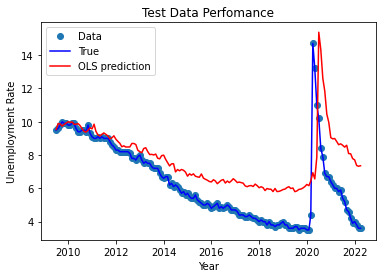

In [9]:
df["L1_LULC"] = df["LULC"].shift(1)
df["L2_LRGDP"] = df["LRGDP"].shift(2)
df["L2_LIP"] = df["LIP"].shift(2)
df["L3_UNRATE"] = df["UNRATE"].shift(3)
df["L3_LRGDP"] = df["LRGDP"].shift(3)
df = df.dropna()

nobs = int(df.shape[0] * 0.4)
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

model = smf.ols("UNRATE ~ L1_LULC + L2_LRGDP + L2_LIP + L3_UNRATE + L3_LRGDP", data = df_train)
results = model.fit()
print(results.summary())

y_true = df_test["UNRATE"]
x_test = df_test[["L1_LULC", "L2_LRGDP", "L2_LIP", "L3_UNRATE", "L3_LRGDP"]]
y_pred = results.predict(x_test)
pred_unrate = y_pred.copy(deep = True)

fig, ax = plt.subplots()
ax.plot(df_test.index, y_true, "o", label="Data")
ax.plot(df_test.index, y_true, "b-", label="True")
ax.plot(df_test.index, y_pred, "r", label="OLS prediction")
ax.legend(loc="best")
ax.set_title("Test Data Perfomance")
ax.set_ylabel("Unemployment Rate")
ax.set_xlabel("Year")
ax.plot()
fig.savefig("Test Data Perfomance")

mse = round(((df_test["UNRATE"] - y_pred)**2).mean(), 4)
print("MSE: ", mse)

MSE:  0.06


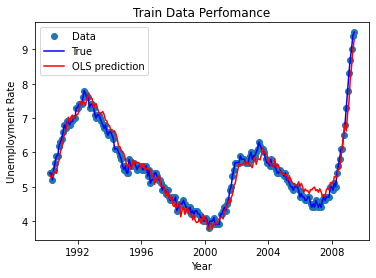

In [10]:
y_true = df_train["UNRATE"]
x_test = df_train[["L1_LULC", "L2_LRGDP", "L2_LIP", "L3_UNRATE", "L3_LRGDP"]]
y_pred = results.predict(x_test)

fig, ax = plt.subplots()
ax.plot(df_train.index, y_true, "o", label="Data")
ax.plot(df_train.index, y_true, "b-", label="True")
ax.plot(df_train.index, y_pred, "r", label="OLS prediction")
ax.legend(loc="best")
ax.set_title("Train Data Perfomance")
ax.set_ylabel("Unemployment Rate")
ax.set_xlabel("Year")
ax.plot()
fig.savefig("Train Data Perfomance")

mse = round(((df_train["UNRATE"] - y_pred)**2).mean(), 4)
print("MSE: ", mse)

# Week 3

$$R_{t}^{T93} = r_{t}^{LR} + \pi_{t} + 0.5(\pi_{t} - \pi^{LR}) + (u_{t}^{LR} - u_{t})$$

$r_{t}^{LR}$: level of the neutral real federal funds rate in the longer run that is expected to be consistent with sustaining maximum employment and inflation at the Federal Open Market Committee's 2 percent longer-run objective, represented by $\pi^{LR}$

$\pi_{t}$ is the 4-quarter price inflation for quarter t

$u_{t}^{LR}$ is the rate of unemployment expected in the longer run

$u_{t}$ is the unemployment rate in quarter t

## Test Taylor rule using GDP gap

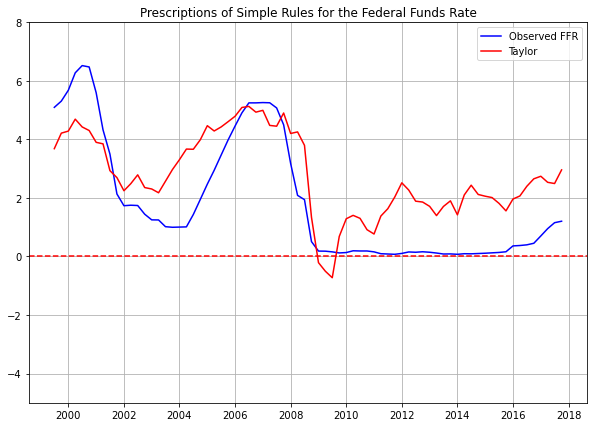

In [11]:
# read csv
rgdp = pd.read_csv("GDPC1.csv", parse_dates = ["DATE"])
egdp = pd.read_csv("GDPPOT.csv", parse_dates = ["DATE"])
fed = pd.read_csv("FEDFUNDS.csv", parse_dates = ["DATE"])
pce = pd.read_csv("PCEPILFE.csv", parse_dates = ["DATE"])
 
# merge
df = rgdp.merge(egdp, how = "inner", on = "DATE")
df = df.merge(fed, how = "inner", on = "DATE")
df = df.merge(pce, how = "inner", on = "DATE")
df["DATE"] = pd.to_datetime(df.DATE)
df = df.set_index(df.DATE)

# inflation & output gap
df["INF"] = df.PCEPILFE.pct_change(periods = 4) * 100
df["OUTGAP"] = (df.GDPC1 - df.GDPPOT) / (df.GDPPOT) * 100
df.dropna(inplace = True)

# Taylor Rule
df["rt"] = 2 + df.INF + 0.5 * (df.INF - 2) + 0.5 * df.OUTGAP

# PLot
plt.figure(figsize = (10, 7))
plt.plot(df.FEDFUNDS["1999-07-01":"2017-10-01"], color = "blue")
plt.plot(df.rt["1999-07-01":"2017-10-01"], color = "red")
plt.axhline(0, linestyle = '--', color = "red")
plt.legend(["Observed FFR", "Taylor"])
plt.title("Prescriptions of Simple Rules for the Federal Funds Rate")
plt.ylim(-5, 8)
plt.grid()
plt.savefig("Prescriptions of Simple Rules for the Federal Funds Rate.png")

## Test Taylor rule using unemployment rate gap

## Test Adjusted Taylor rule using unemployment rate gap

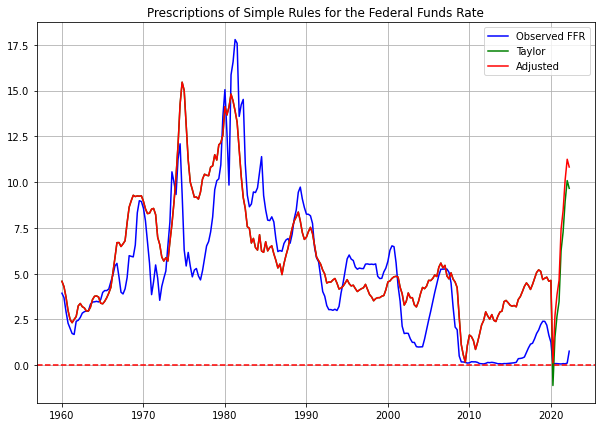

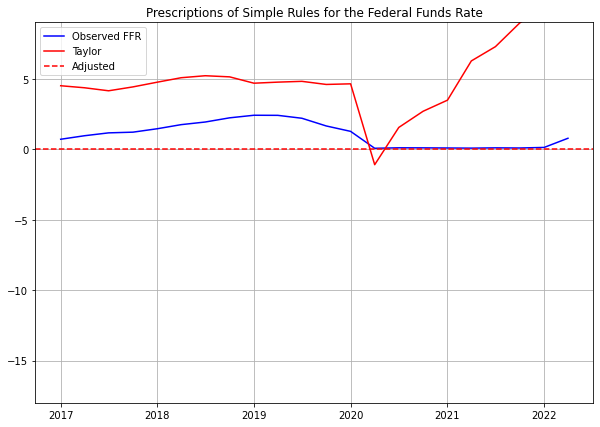

In [12]:
# read csv
fed = pd.read_csv("FEDFUNDS.csv", parse_dates = ["DATE"])
pce = pd.read_csv("PCEPILFE.csv", parse_dates = ["DATE"])
unrate = pd.read_csv("UNRATE.csv", parse_dates = ["DATE"])

# merge
df = fed.merge(pce, how = "inner", on = "DATE")
df = df.merge(unrate, how = "inner", on = "DATE")
df["DATE"] = pd.to_datetime(df.DATE)
df = df.set_index(df.DATE)

# inflation
df["INF"] = df.PCEPILFE.pct_change(periods = 4) * 100
df.dropna(inplace = True)

# Taylor Rule
df["rt"] = 2 + df.INF + 0.5 * (df.INF - 2) + 0.5 * (df.UNRATE.mean() - df.UNRATE)

# Adjusted Taylor Rule
df["sig"] = np.where(df.rt < 0, df.rt - df.FEDFUNDS, 0)
df["zt"] = df.sig.cumsum()
df["adj_rt"] = np.where(df.rt - df.zt > 0.125, df.rt - df.zt, 0.125)

# Plot
plt.figure(figsize = (10, 7))
plt.plot(df.FEDFUNDS, color = "blue")
plt.plot(df.rt, color = "green")
plt.plot(df.adj_rt, color = "red")
plt.axhline(0, linestyle = '--', color = "red")
plt.legend(["Observed FFR", "Taylor", "Adjusted"])
plt.title("Prescriptions of Simple Rules for the Federal Funds Rate")
#plt.ylim(-18, 9)
plt.grid()

# Plot
plt.figure(figsize = (10, 7))
plt.plot(df.FEDFUNDS["2017-01-01":], color = "blue")
plt.plot(df.rt["2017-01-01":], color = "red")
plt.axhline(0, linestyle = '--', color = "red")
plt.legend(["Observed FFR", "Taylor", "Adjusted"])
plt.title("Prescriptions of Simple Rules for the Federal Funds Rate")
plt.ylim(-18, 9)
plt.grid()
plt.savefig("Prescriptions of Simple Rules use Unrate for the Federal Funds Rate.png")

## Taylor rule using predict unemployment rate gap

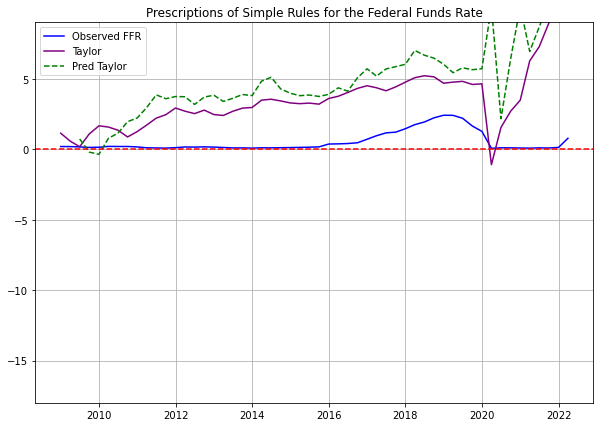

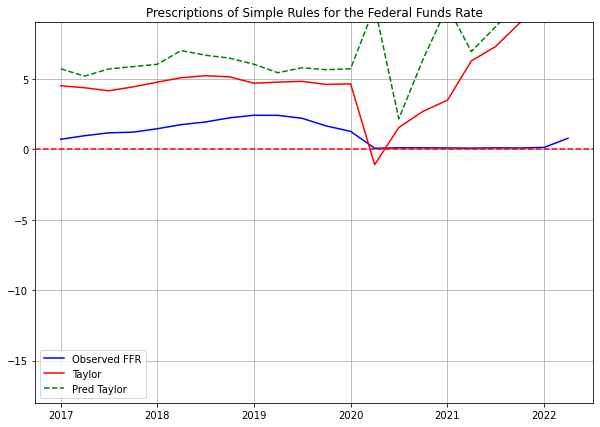

In [13]:
# predict taylor rule
pred = pd.concat([pred_unrate, pred_inf], axis = 1).dropna(axis = 0)
pred.columns = ["UNRATE", "INF"]
pred["pre_rt"] = 2 + pred.INF + 0.5 * (pred.INF - 2) + (pred.UNRATE.mean() - pred.UNRATE)
#pred["pre_rt"] = np.where(pred.pre_rt > 0.125, pred.pre_rt, 0.125)

# Plot
plt.figure(figsize = (10, 7))
plt.plot(df.FEDFUNDS["2009-01-01":], color = "blue")
plt.plot(df.rt["2009-01-01":], color = "purple")
plt.plot(pred.pre_rt["2009-01-01":], linestyle = "--", color = "green")
plt.axhline(0, linestyle = '--', color = "red")
plt.legend(["Observed FFR", "Taylor", "Pred Taylor"])
plt.title("Prescriptions of Simple Rules for the Federal Funds Rate")
plt.ylim(-18, 9)
plt.grid()

# Plot
plt.figure(figsize = (10, 7))
plt.plot(df.FEDFUNDS["2017-01-01":], color = "blue")
plt.plot(df.rt["2017-01-01":], color = "red")
plt.plot(pred.pre_rt["2017-01-01":], linestyle = "--", color = "green")
plt.axhline(0, linestyle = '--', color = "red")
plt.legend(["Observed FFR", "Taylor", "Pred Taylor"])
plt.title("Prescriptions of Simple Rules for the Federal Funds Rate")
plt.ylim(-18, 9)
plt.grid()
plt.savefig("Prescriptions of Simple Rules use Unrate for the Federal Funds Rate.png")

# Logistic using prediction of inf and unrate; THRESHOLD = 0.5

In [14]:
# real federal funds rate signal
df["fdd_signal"] = np.where(df.FEDFUNDS.diff(periods = 1) >= 0, 1, 0)
df["shift_fdd_signal"] = df["fdd_signal"].shift(-1)
df.dropna(inplace = True)

# merge predict value and real signal
clf = pd.merge(df[["fdd_signal", "shift_fdd_signal", "FEDFUNDS"]], pred, left_index = True, right_index = True)
clf["DIF"] = clf.pre_rt - clf.FEDFUNDS
#clf = pd.merge(df, pred.pre_rt, left_index = True, right_index = True)

# data split
from sklearn.model_selection import train_test_split
X = clf[["DIF"]]
y = clf[["shift_fdd_signal"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [15]:
# Preprocessing
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

In [16]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

<AxesSubplot:xlabel='DIF'>

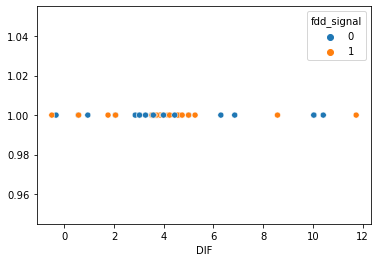

In [32]:
sns.scatterplot(data = clf, x = "DIF", y = 1, hue = "fdd_signal")

In [18]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state = 0)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# threshold = 0.95
THRESHOLD = 0.95
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.14      0.25         7
         1.0       0.40      1.00      0.57         4

    accuracy                           0.45        11
   macro avg       0.70      0.57      0.41        11
weighted avg       0.78      0.45      0.37        11



# SVM Prediction Taylor Rule

In [19]:
# read csv
fed = pd.read_csv("FEDFUNDS.csv", parse_dates = ["DATE"])
pce = pd.read_csv("PCEPILFE.csv", parse_dates = ["DATE"])
unrate = pd.read_csv("UNRATE.csv", parse_dates = ["DATE"])

# merge
df = fed.merge(pce, how = "inner", on = "DATE")
df = df.merge(unrate, how = "inner", on = "DATE")
df["DATE"] = pd.to_datetime(df.DATE)
df = df.set_index(df.DATE)

# inflation
df["INF"] = df.PCEPILFE.pct_change(periods = 4) * 100
df.dropna(inplace = True)

# Taylor Rule
df["rt"] = 2 + df.INF + 0.5 * (df.INF - 2) + 0.5 * (df.UNRATE.mean() - df.UNRATE)

# predict taylor rule
pred = pd.concat([pred_unrate, pred_inf], axis = 1).dropna(axis = 0)
pred.columns = ["UNRATE", "INF"]
pred["pre_rt"] = 2 + pred.INF + 0.5 * (pred.INF - 2) + (pred.UNRATE.mean() - pred.UNRATE)

# real federal funds rate signal
df["fdd_signal"] = np.where(df.FEDFUNDS.diff(periods = 1) >= 0, 1, 0)
df["shift_fdd_signal"] = df["fdd_signal"].shift(-1)
df.dropna(inplace = True)

# merge predict value and real signal
clf = pd.merge(df[["fdd_signal", "shift_fdd_signal", "FEDFUNDS"]], pred, left_index = True, right_index = True)
clf["DIF"] = clf.pre_rt - clf.FEDFUNDS
#clf = pd.merge(df, pred.pre_rt, left_index = True, right_index = True)

# data split
from sklearn.model_selection import train_test_split
X = clf[["DIF"]]
y = clf[["shift_fdd_signal"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

<AxesSubplot:xlabel='DIF', ylabel='DIF'>

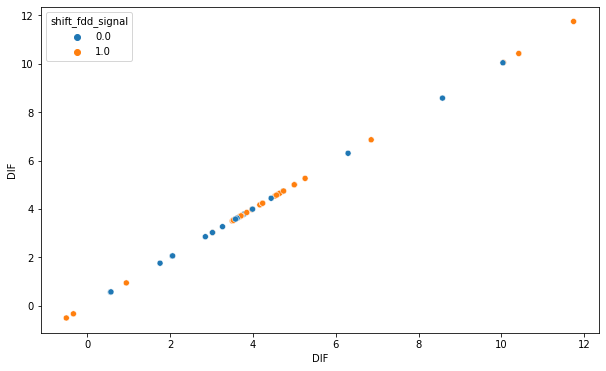

In [20]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = clf, x = "DIF", y = clf.DIF, hue = "shift_fdd_signal")
#plt.savefig("Scatter Plot.png")

In [21]:
# Preprocessing
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [22]:
from sklearn import svm
model = svm.SVC()
result = model.fit(X_train, y_train)
y_pred = result.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73         7
         1.0       0.57      1.00      0.73         4

    accuracy                           0.73        11
   macro avg       0.79      0.79      0.73        11
weighted avg       0.84      0.73      0.73        11



In [23]:
print(y_pred, y_test)

[0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.]             shift_fdd_signal
DATE                        
2019-07-01               0.0
2019-10-01               0.0
2020-01-01               0.0
2020-04-01               1.0
2020-07-01               0.0
2020-10-01               0.0
2021-01-01               0.0
2021-04-01               1.0
2021-07-01               0.0
2021-10-01               1.0
2022-01-01               1.0


In [24]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'sigmoid', 'poly']} 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.625 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.625 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.625 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.625 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.625 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.625 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.625 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.625 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.625 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoi

[CV 1/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.625 total time=   0.0s
[CV 2/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.625 total time=   0.0s
[CV 3/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.625 total time=   0.0s
[CV 4/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.625 total time=   0.0s
[CV 5/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 1/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.625 total time=   0.0s
[CV 2/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.625 total time=   0.0s
[CV 3/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.625 total time=   0.0s
[CV 4/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.625 total time=   0.0s
[CV 5/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.625 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.625 total time=   0.0s
[CV 3/5] END ......C=1, gamm

[CV 5/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 1/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.625 total time=   0.0s
[CV 2/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.625 total time=   0.0s
[CV 3/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.625 total time=   0.0s
[CV 4/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.625 total time=   0.0s
[CV 5/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.750 total time=   0.0s
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.625 total time=   0.0s
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 3/5] END ........C=100, gamma=1, kernel=rbf;, score=0.625 total time=   0.0s
[CV 4/5] END ........C=100, gamma=1, kernel=rbf;, score=0.625 total time=   0.0s
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 1/5] END .....C=100, gamma=1, kernel=linear;, score=0.625 total time=   0.0s
[CV 2/5] END .....C=100, gam

[CV 2/5] END ......C=1000, gamma=1, kernel=poly;, score=0.625 total time=   3.5s
[CV 3/5] END ......C=1000, gamma=1, kernel=poly;, score=0.625 total time=   3.8s
[CV 4/5] END ......C=1000, gamma=1, kernel=poly;, score=0.625 total time=   4.0s
[CV 5/5] END ......C=1000, gamma=1, kernel=poly;, score=0.750 total time=   2.8s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.625 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.625 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 1/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.625 total time=   0.0s
[CV 2/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.625 total time=   0.0s
[CV 3/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.625 total time=   0.0s
[CV 4/5] END ..C=1000, gamma

In [25]:
grid_predictions = grid.predict(X_test)
  
# print classification report
print(metrics.classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73         7
         1.0       0.57      1.00      0.73         4

    accuracy                           0.73        11
   macro avg       0.79      0.79      0.73        11
weighted avg       0.84      0.73      0.73        11



In [26]:
print(grid_predictions, y_test)

[0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.]             shift_fdd_signal
DATE                        
2019-07-01               0.0
2019-10-01               0.0
2020-01-01               0.0
2020-04-01               1.0
2020-07-01               0.0
2020-10-01               0.0
2021-01-01               0.0
2021-04-01               1.0
2021-07-01               0.0
2021-10-01               1.0
2022-01-01               1.0


# SVM Real Taylor Rule

In [27]:
def feature_map_2(X):  
    return np.asarray((X[:,0], np.exp(-(X[:,0]**2)))).T

<AxesSubplot:>

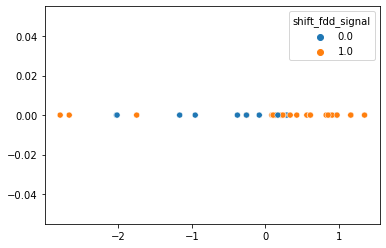

In [28]:
Z = feature_map_2(X_train)

# 1D scatter plot
sns.scatterplot(data = y_train, x = X_train[:, 0], y = 0, hue = "shift_fdd_signal")

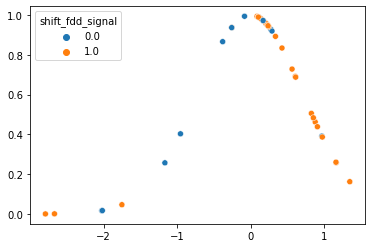

In [29]:
#2D scatter plot
sns.scatterplot(data = y_train, x = Z[:, 0], y = Z[:, 1], hue = "shift_fdd_signal")
plt.savefig("SVM 2 Dimentional.png")